In [47]:
import cox 
from cox.store import Store
from cox.readers import CollectionReader 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch as ch 
from torch import Tensor
from torch.distributions import Uniform
import os 
# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [6]:
reader = CollectionReader('/home/gridsan/stefanou/Regression/TruncReg')
logs = reader.df('results')
reader.close()
logs.head()

100%|██████████| 11/11 [00:02<00:00,  5.18it/s]


,known_param_mse,unknown_param_mse,unknown_var_mse,ols_param_mse,ols_var_mse,trunc_reg_param_mse,trunc_var_mse,alpha,var,exp_id
0,0.068171,0.087442,0.214402,0.158803,0.226417,0.425388,0.000093,0.6598,1.0,24d3318f-f193-44c9-94cc-8e5440276b2b
1,0.187125,0.199901,0.876496,0.372558,1.125606,0.724831,0.328448,0.6257,2.0,24d3318f-f193-44c9-94cc-8e5440276b2b
2,0.316339,0.273816,1.710094,0.604417,2.770865,1.039533,1.542299,0.6071,3.0,24d3318f-f193-44c9-94cc-8e5440276b2b
3,0.463008,0.322711,2.513590,0.851743,5.170775,1.357532,3.872344,0.5941,4.0,24d3318f-f193-44c9-94cc-8e5440276b2b
4,0.618353,0.339473,3.188772,1.106882,8.336219,1.678045,7.439244,0.5848,5.0,24d3318f-f193-44c9-94cc-8e5440276b2b


In [59]:
logs[['unknown_param_mse', 'unknown_var_mse', 'var', 'alpha']].head(25)

,unknown_param_mse,unknown_var_mse,var,alpha
0,0.087442,0.214402,1.0,0.6598
1,0.199901,0.876496,2.0,0.6257
2,0.273816,1.710094,3.0,0.6071
3,0.322711,2.513590,4.0,0.5941
4,0.339473,3.188772,5.0,0.5848
5,0.279946,3.134308,6.0,0.5788
6,0.252395,3.410636,7.0,0.5716
7,0.238272,3.445451,8.0,0.5660
8,0.204411,2.964363,9.0,0.5622
9,0.160044,3.017436,10.0,0.5587


In [19]:
trunc_df = pd.read_csv('/home/gridsan/stefanou/truncreg/result.csv')
trunc_df

,Unnamed: 0,x
0,(Intercept),0.348450
1,X,-0.183805
2,sigma,4.488615


In [25]:
U = Uniform(-1, 1)
# U_ = Uniform(args.x_lower, args.x_upper)

In [48]:
ch.nn.MSELoss()(Tensor([trunc_df['x'][2]**2]), Tensor([20]))

tensor(0.0218)

In [27]:
ch.manual_seed(1)
# generate ground truth
ground_truth = ch.nn.Linear(in_features=1, out_features=1, bias=True)
ground_truth.weight = ch.nn.Parameter(U.sample(ch.Size([1, 1])))
ground_truth.bias = ch.nn.Parameter(U.sample(ch.Size([1, 1])))

In [32]:
params = ch.cat([ground_truth.weight, ground_truth.bias])
trunc_params = ch.cat([Tensor([trunc_df['x'][1]]), Tensor([trunc_df['x'][0]])])

In [35]:
trunc_params, params

(tensor([-0.1838,  0.3484]),
 tensor([[-0.1939],
         [ 0.4694]], grad_fn=<CatBackward>))

In [57]:
ch.nn.MSELoss()(trunc_params, params.flatten()), ch.nn.MSELoss()(Tensor([trunc_df['x'][2]])**2, Tensor([20]))

(tensor(0.0074, grad_fn=<MseLossBackward>), tensor(0.0218))

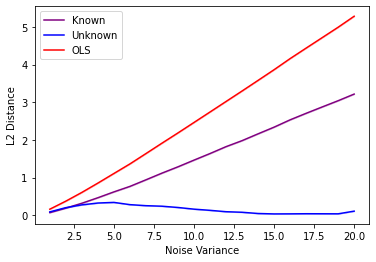

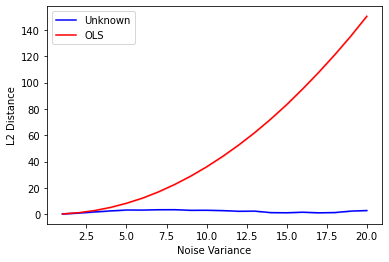

In [60]:
sns.lineplot(data=logs, x='var', y='known_param_mse', label='Known', color="purple")
sns.lineplot(data=logs, x='var', y='unknown_param_mse', label='Unknown', color="blue")
ax = sns.lineplot(data=logs, x='var', y='ols_param_mse', label='OLS', color="red")
# ax = sns.lineplot(data=logs, x='var', y='trunc_reg_param_mse', label='truncreg', color="yellow")
ax.set(xlabel='Noise Variance', ylabel='L2 Distance')
plt.show()

# sns.lineplot(data=logs, x='var', y='known_', label='Known', color="purple")
sns.lineplot(data=logs, x='var', y='unknown_var_mse', label='Unknown', color="blue")
ax = sns.lineplot(data=logs, x='var', y='ols_var_mse', label='OLS', color="red")
# ax = sns.lineplot(data=logs, x='var', y='trunc_var_mse', label='truncreg', color="yellow")
ax.set(xlabel='Noise Variance', ylabel='L2 Distance')
plt.show()


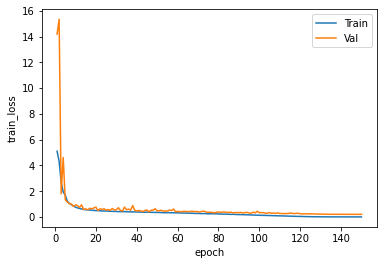

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

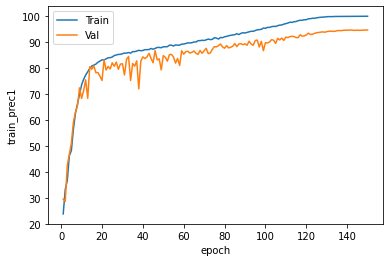

In [41]:
sns.lineplot(data=logs, x='epoch', y='train_loss', label='Train')
sns.lineplot(data=logs, x='epoch', y='val_loss', label='Val')
plt.show()
sns.lineplot(data=logs, x='epoch', y='train_prec1', label='Train')
sns.lineplot(data=logs, x='epoch', y='val_prec1', label='Val')

In [35]:
reader.close()

<AxesSubplot:xlabel='epoch', ylabel='train_prec1'>

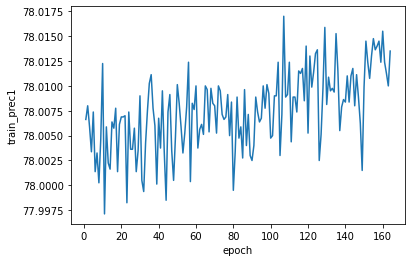

In [20]:
sns.lineplot(data=trunc, x='epoch', y='train_prec1')